In [153]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import random
import torch.nn.utils
import textwrap
import re
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import torch.nn.functional as F
from transformers import AutoTokenizer
from datasets import load_dataset, Dataset
import math
import datasets
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity

In [140]:
torch.cuda.empty_cache()

In [161]:
import os



tokenized_dataset_path = os.getcwd() + '/tokenized_train_dataset'

print(os.path.isdir(tokenized_dataset_path))

def tokenization(example):
    
    # tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    
    # tokenizer.pad_token = tokenizer.eos_token
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
    tokenized_output = tokenizer(example['text'], truncation=True)
    tokenized_output['input_ids'] = [tokens + [tokenizer.encode(tokenizer.eos_token)[1]] for tokens in tokenized_output['input_ids']]
    return tokenized_output

def chunk_examples(examples):
    window = 250
    all_tokens = [token for example in examples for token in example['input_ids']]
    chunks = [all_tokens[i:i + window] for i in range(0, len(all_tokens), window)]
    return Dataset.from_dict({"tokens": chunks})

def generate_tokenized_dataset(train: bool=True) -> DataLoader:
    # tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
    tokenizer.pad_token = tokenizer.eos_token
    if train:
        dataset_type = "train"
        tokenized_dataset_folder = 'tokenized_train_dataset'
        tokenized_dataset_path = os.getcwd() + '/' + tokenized_dataset_folder
    else:
        dataset_type = "validation"
        tokenized_dataset_folder = 'tokenized_validation_dataset'
        tokenized_dataset_path = os.getcwd() + '/tokenized_validation_dataset'
    
    print(os.getcwd())

    if os.path.isdir(tokenized_dataset_path):
        tokenized_entries = datasets.load_from_disk(tokenized_dataset_folder)
       
    else:
        dataset = load_dataset("roneneldan/TinyStories")
        dataset = dataset[dataset_type]
        updated_dataset = dataset#.map(chunk_examples, batched=True, remove_columns=dataset.column_names, num_proc=5)
        tokenized_entries = updated_dataset.map(tokenization, batched=True, num_proc=8)
        print(tokenized_entries)
        tokenized_entries = chunk_examples(tokenized_entries)
        # tokenized_entries = tokenized_entries.map(pad_tokens, batched=True, num_proc=8)
        # tokenized_entries = tokenized_entries.map(tokenization, batched=True, num_proc=8)
        tokenized_entries.save_to_disk(tokenized_dataset_folder)
       
        
    
    # data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    # data_loader = DataLoader(tokenized_entries, batch_size=4, shuffle=True, collate_fn=data_collator)
    # return data_loader
    return tokenized_entries

True


In [163]:
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
# tokenizer.pad_token = tokenizer.eos_token

# train_loader = generate_tokenized_dataset(True)
entries = generate_tokenized_dataset(True)

c:\Users\scott\OneDrive\Documents\GitHub\ESE546Project


Map (num_proc=8): 100%|██████████| 2119719/2119719 [09:24<00:00, 3756.51 examples/s]


Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 2119719
})


Saving the dataset (8/8 shards): 100%|██████████| 1979316/1979316 [00:20<00:00, 95386.63 examples/s] 


In [164]:
print(entries)

Dataset({
    features: ['tokens'],
    num_rows: 1979316
})


In [165]:
print("len: " + str(len(entries['tokens'][4])))
print(tokenizer.decode(entries['tokens'][4]))

print("-------------")

print("len: " + str(len(entries['tokens'][5])))
print(tokenizer.decode(entries['tokens'][5]))

print("-------------")

print("len: " + str(len(entries['tokens'][6])))
print(tokenizer.decode(entries['tokens'][6]))

In [92]:
print(tokenizer.decode(tokenizer.encode(tokenizer.eos_token)[1]))
print(tokenizer.eos_token)

</s>
</s>


In [84]:
print(len(train_loader.sampler))
print(len(train_loader))

2119719
529930


In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [16]:
# input_feature_dim = m
# input_feature_dim = 50257
input_feature_dim = tokenizer.vocab_size
hidden_size = 256
# hidden_size = 2048

In [34]:
class TransformerModel(nn.Module):
    def __init__(self, input_feature_dim, d_model, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_feature_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=0.1,dim_feedforward=2048),
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model),
        )
        self.fc = nn.Linear(d_model, input_feature_dim)
        self.pos_encoder = PositionalEncoding(d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        mask = self.generate_square_subsequent_mask(len(x[0])).to(device)
        x = x.permute(1,0,2)
        x = self.transformer(x, mask)
        x = x.permute(1,0,2)
        x = self.fc(x)
        return x
    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        
        x = x + (self.pe[:x.size(0)])
        return x

In [69]:
def trainLR(net, optimizer, criterion, train_loader, scheduler):
    model = net.to(device)
    train_loss = []
    lrs = []
    for k, input in enumerate(train_loader):
        if k >= 100:
            return train_loss, lrs
        
        sequence = torch.tensor(input['input_ids']).to(device)
        model.train()
        labels = sequence[:,1:].contiguous().view(-1)
        output = model(sequence[:,:-1])
        
        output = output.view(-1, output.size(-1))
        
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        
        scheduler.step()
        lrs.append(scheduler.get_last_lr())
        train_loss.append(loss.item())

        del loss, output, labels

    return train_loss, lrs

In [74]:
losses = np.zeros(100)
all_lrs = np.zeros(100)
for i in range(10):
    print(i)
    num_heads = 6
    num_layers = 6
    transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
    # transformer_model = TransformerModel(input_feature_dim, int(input_feature_dim/2) - (int(input_feature_dim/2) % 4)).to(device)
    pad_token = tokenizer.encode(tokenizer.pad_token)[0]
    criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
    optimizer = optim.AdamW(transformer_model.parameters(), lr = 0.00001, betas=(0.9, 0.95))
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.1)


    loss, lrs = trainLR(transformer_model, optimizer, criterion, train_loader, scheduler)
    losses += np.array(loss)
    all_lrs = np.array(lrs)

losses /= 10
all_lrs /= 10

0


c:\Users\scott\anaconda3\envs\venv\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\scott\AppData\Local\Temp\ipykernel_6280\1746498973.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(input['input_ids']).to(device)


1
2
3
4
5
6
7
8
9


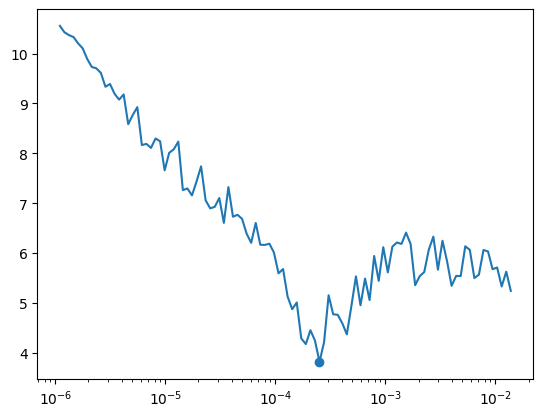

In [80]:
fig1, ax1 = plt.subplots()
ax1.set_xscale('log')
ax1.plot(all_lrs, losses)
ax1.scatter(0.00025, np.amin(losses))

In [116]:
print(len(train_loader)/5)

105986.0


In [118]:
def customScheduler(t, n_max, epochs):
    T = epochs*len(train_loader)
    T0 = float(T/5)

    if t <= T0:
        return pow(10, -8) + n_max*t/T0
    else:
        return n_max*np.cos(np.pi/2*(t-T0)/(T-T0)) + pow(10, -10)

In [119]:
num_heads = 6
num_layers = 6
transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
# transformer_model = TransformerModel(input_feature_dim, int(input_feature_dim/2) - (int(input_feature_dim/2) % 4)).to(device)
pad_token = tokenizer.encode(tokenizer.pad_token)[0]
criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
optimizer = optim.AdamW(transformer_model.parameters(), lr = 0.000025, betas=(0.9, 0.95))
# scheduler = MultiStepLR(optimizer, milestones=[2500, 7000], gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
# train_temperature = 1.0


c:\Users\scott\anaconda3\envs\venv\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [92]:
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

In [88]:
# print(summary(transformer_model, (1,m)))
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)


23903648


In [45]:
# combined_string = dataset['train'][:]['text']

# batch_size = 250
# batches = [combined_string[i:i+batch_size][0] for i in range(0, len(combined_string), batch_size)]
# if len(batches[-1]) != batch_size:
#     batches.pop()

# char_1 = 0
# batches = batches
# for i in batches:
#     char_1 += len(i)
# print(len(batches))
# print(len(combined_string))
# # print(batches[-1])
# print(dataset['train'][-1])
# print(combined_string[-1])
# batches = dataset['train']
# chars = 0
# for i,batch in enumerate(batches):
#     chars += len(batch['text'])
# # print(i)
# print(char_1)
# print(chars)
# num_sequences = 30000

In [120]:
num_epochs = 1
training_loss_values = []
training_error_values = []
validation_loss_values = []
validation_error_values = []
x_vals = []
lrs = []
x_val = 1
validation_x_vals = []
num_validation_seq = 5


for epoch in range(num_epochs):

    # loss_accumulator = 0
    # error_accumulator = 0
    
    for i,input in enumerate(train_loader):
        # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
        #              record_shapes=True, 
        #              profile_memory=True, 
        #              use_cuda=torch.cuda.is_available()) as prof:
    # for i, input in enumerate(batches):
            # input = input['text']
            lr = customScheduler(i, 0.000025, 1)
            lrs.append(lr)
            for g in optimizer.param_groups:
                g[lr] = lr
            sequence = torch.tensor(input['input_ids']).to(device)
            # attn_mask = torch.tensor(input['attention_mask'])[:, 1:].to(device)
            # print(attn_mask.shape)
            # print(sequence.shape)
            transformer_model.train()
            # tokens = encoding.encode(input)
            # sequence = torch.tensor(tokens).long().to(device)
            labels = sequence[:,1:].contiguous().view(-1)
            output = transformer_model(sequence[:,:-1])
            # print(output.shape)
            # pad_tensor = torch.zeros_like(output)
            # pad_tensor[:, :, pad_token] = 1
            # attn_mask = attn_mask.unsqueeze(2).repeat(1,1,50257)
            # # print(attn_mask.unsqueeze(2).repeat(1,1,50257).shape)
            # output = torch.where(attn_mask==1, output, pad_tensor)
            
            output = output.view(-1, output.size(-1))
            
            loss = criterion(output,labels)
            # softmaxed_logits = softmax_with_temperature(output, train_temperature)
            # loss = nn.NLLLoss()(torch.log(softmaxed_logits), labels)
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 15.0)
            # loss_accumulator += loss.item()
            optimizer.step()
            # training_loss_values.append(loss.item())
            
            predicted_labels = torch.argmax(output,dim=1)
            training_error = 1.0 - (labels == predicted_labels).sum()/(len(labels))
            # training_error_values.append(training_error.item())
            # error_accumulator += training_error.item()

            # x_vals.append(x_val)

            # if x_val % 50 == 0:  # If 50 iterations have passed
            #     avg_loss = loss_accumulator / 50.0
            #     avg_error = error_accumulator / 50.0
            #     training_loss_values.append(avg_loss)
            #     training_error_values.append(avg_error)
            #     x_vals.append(x_val)
            #     # Reset the accumulators
            #     loss_accumulator = 0
            #     error_accumulator = 0

            training_loss_values.append(loss.item())
            training_error_values.append(training_error.item())

            if (x_val % 1000) == 0:
                transformer_model.eval()
                print('Iteration: {}/{}'.format(x_val, len(train_loader)))
            
            if x_val==10000:
                break
                
            x_val +=1

            del loss, output, labels
        # print(prof.key_averages().table(sort_by="cuda_time_total"))
            # scheduler.step()

C:\Users\scott\AppData\Local\Temp\ipykernel_6280\2482872185.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(input['input_ids']).to(device)


Iteration: 1000/529930
Iteration: 2000/529930
Iteration: 3000/529930
Iteration: 4000/529930
Iteration: 5000/529930
Iteration: 6000/529930
Iteration: 7000/529930
Iteration: 8000/529930
Iteration: 9000/529930
Iteration: 10000/529930


[2.3598021059385203e-05, 2.3598256939595797e-05, 2.3598492819806394e-05, 2.3598728700016987e-05, 2.359896458022758e-05, 2.3599200460438175e-05, 2.359943634064877e-05, 2.3599672220859362e-05, 2.3599908101069953e-05, 2.3600143981280546e-05, 2.3600379861491144e-05, 2.3600615741701737e-05, 2.360085162191233e-05, 2.3601087502122925e-05, 2.360132338233352e-05, 2.3601559262544112e-05, 2.3601795142754706e-05, 2.3602031022965303e-05, 2.3602266903175897e-05, 2.360250278338649e-05, 2.360273866359708e-05, 2.3602974543807674e-05, 2.3603210424018268e-05, 2.3603446304228862e-05, 2.3603682184439456e-05, 2.3603918064650053e-05, 2.3604153944860646e-05, 2.360438982507124e-05, 2.3604625705281834e-05, 2.3604861585492428e-05, 2.3605097465703018e-05, 2.360533334591361e-05, 2.3605569226124205e-05, 2.3605805106334802e-05, 2.3606040986545396e-05, 2.360627686675599e-05, 2.3606512746966584e-05, 2.3606748627177177e-05, 2.360698450738777e-05, 2.3607220387598365e-05, 2.3607456267808962e-05, 2.3607692148019555e-05, 2

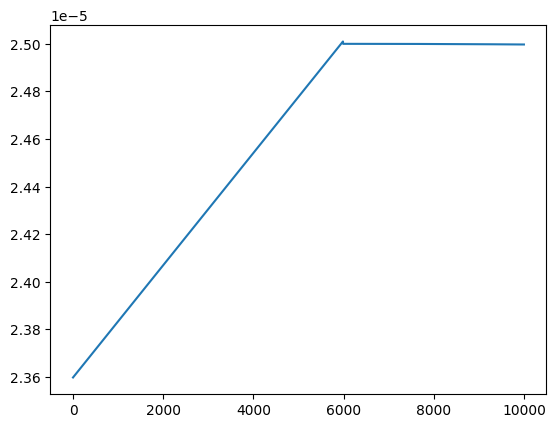

In [121]:
plt.plot(lrs)

print(lrs)

In [49]:
# torch.save(transformer_model.state_dict(), 'transformer_model.pth')
# print('Model saved')

Model saved


<Figure size 640x480 with 0 Axes>

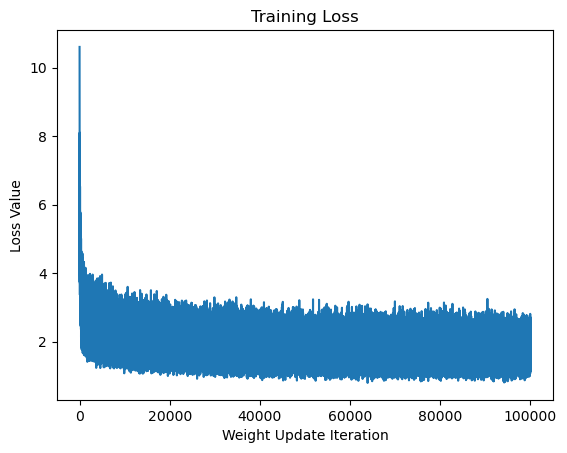

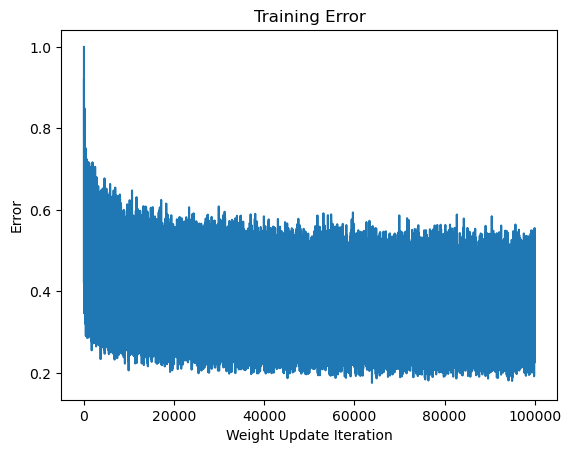

<Figure size 640x480 with 0 Axes>

In [20]:
# output,_ = rnn(input[40].to(device))
# output = [unique_chars[i] for i in torch.argmax(output, dim=1).tolist()]
# output = torch.tensor(unique_chars)
# [torch.argmax(output, dim=1)]
# print(batches[40])
# # print((output))
# # print(output)
# print(error)
# print(current_labels)
# print(torch.argmax(output,dim=1))
# test = [1,2,3,4,5]

# training_error_values = [i.cpu().item() for i in training_error_values]
# validation_error_values = [i.cpu().item() for i in validation_error_values]
# validation_loss_values = [i.cpu().item() for i in validation_loss_values]
x_vals = np.arange(x_val)

plt.figure()
plt.plot(x_vals[0:200000],training_loss_values[0:200000])
plt.xlabel('Weight Update Iteration')
plt.ylabel('Loss Value')
plt.title('Training Loss')
plt.figure()
plt.plot(x_vals[0:200000], training_error_values[0:200000])
plt.xlabel('Weight Update Iteration')
plt.ylabel('Error')
plt.title('Training Error')
plt.figure()
# plt.plot(validation_x_vals, validation_loss_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Loss Value')
# plt.title('Validation Loss')
# plt.figure()
# plt.plot(validation_x_vals, validation_error_values)
# plt.xlabel('Weight Update Iteration')
# plt.ylabel('Error')
# plt.title('Validation Error')
# plt.show()

In [25]:
test_temperature = 0.9
transformer_model.eval()
capital_letters = [chr(i) for i in range(65, 91)]
example_sentences = []
#initialize = ["I went to the store."]
initialize = ['Alice and Jack walked up the street and met a girl in a red dress. The girl said to them, ”Hi, I’m Jane. What are your names?”']
# initialize = ['Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is']
inference_tokens = 100
for i in range(1):
    sentence = initialize[i]
    tokenized_sentence = tokenizer.encode(sentence)
    next_char = torch.tensor(tokenized_sentence).long().unsqueeze(0).to(device)
    for j in range(inference_tokens):
        next_char = transformer_model(next_char)
        # print(next_char.shape)
        # print(next_char.shape)
        next_softmax = softmax_with_temperature(next_char, test_temperature)
        # predicted_char = torch.argmax(next_softmax,dim=1)
        predicted_char = torch.multinomial(next_softmax[0,-1],1)
        # letter = unique_chars[predicted_char[-1]]
        letter = tokenizer.decode([predicted_char.item()])
        sentence += letter
        # next_char = torch.tensor(tokenize(sentence)).long().to(device)
        next_tokenized_sentence = tokenizer.encode(sentence)
        next_char = torch.tensor(next_tokenized_sentence).unsqueeze(0).long().to(device)
    example_sentences.append(sentence)
example_sentences = np.array(example_sentences)
print(example_sentences[0])
# print(example_sentences[1])
# print(example_sentences[2])
# print(example_sentences[3])
# print(example_sentences[4])

Alice and Jack walked up the street and met a girl in a red dress. The girl said to them, ”Hi, I’m Jane. What are your names?”?"

Lucysmiledandmarepliedcharminginledinandaghettiforledwithed.

"AMay!"saidsaidthecats.

"Iwantwhatlikeso,"said."

standing岛atyrepliedandpatight'seyes."

"It'sa,"saidsaidthepointingtheilledtooed.

"Itlookssoup,"saidsaidsaidas,pointingherdiscoverherbelongedwith.

"
